In [1]:
import numpy as np
import matplotlib.pyplot as plt

### bandit

| 老虎机   | 能获得的硬币数量 | 0    | 1    | 5    | 10   |
|---------|------------------|------|------|------|------|
| 老虎机 A | 概率             | 0.70 | 0.15 | 0.12 | 0.03 |
| 老虎机 B | 概率             | 0.50 | 0.40 | 0.09 | 0.01 |

- $Q(A)$ 表示行动价值（Q：Quality）
    - $Q(A)=\mathbb E[R|A]$
- 基于样本均值计算 $Q$
    - $Q_{n-1}=\frac{R_1+R_2+\cdots+R_{n-1}}{n-1}$
        - $R_1+R_2+\cdots+R_{n-1}=(n-1)Q_{n-1}$
    - $Q_n=\frac{R_1+R_2+\cdots+R_n}{n}=(1-\frac1n)Q_{n-1}+\frac1nR_n$
        - $Q_n=Q_{n-1}+\frac1n(R_n-Q_{n-1})$
        - 代码层面（iter）
            - $Q=Q+(reward-Q)/n$
- 则以 $Q_{n-1}$ 为基准
    - $Q_{n-1}+\frac1n(R_n-Q_{n-1}) \rightarrow Q_n$
        - $\frac1n(R_n-Q_{n-1})$ 为要更新的量，
    - $Q_{n-1}+(R_n-Q_{n-1})\rightarrow R_n$

In [2]:
Q = 0
for n in range(1, 6):
    reward = np.random.rand()
    Q = Q + (reward - Q) / n
    print(Q)

0.7101176389956885
0.5459402370526161
0.5888229465162428
0.5006260347769713
0.5272529602535758


In [3]:
class Bandit:
    def __init__(self, arms):
        self.rates = np.random.rand(arms)
    def play(self, arm):
        rate = np.random.rand()
        return int(rate > self.rates[arm])

In [4]:
arms = 10
bandit = Bandit(arms)
for _ in range(3):
    arm = np.random.choice(range(arms))
    print(bandit.play(arm))

1
1
1


In [5]:
arms = 10
bandit = Bandit(arms)
print(bandit.rates)
Qs = np.zeros(arms)
ns = np.zeros(arms)

for n in range(100):
    action = np.random.randint(0, arms)
    ns[action] += 1
    reward = bandit.play(action)
    Qs[action] += (reward - Qs[action]) / ns[action]
print(Qs)

[0.88288728 0.92017849 0.38426054 0.87891314 0.5791566  0.69518961
 0.63435815 0.60369358 0.95436871 0.71652993]
[0.07692308 0.15384615 0.8        0.1        0.         0.5
 0.4        0.33333333 0.         0.54545455]


In [6]:
class Agent:
    def __init__(self, arms, epsilon=0.1):
        self.epsilon = epsilon
        self.Qs = np.zeros(arms)
        self.ns = np.zeros(arms)
        self.arms = arms
    def update(self, action, reward):
        self.ns[action] += 1
        self.Qs[action] += (reward - self.Qs[action]) / self.ns[action]
    def get_action(self):
        p = np.random.rand()
        if p < self.epsilon:
            return np.random.randint(0, self.arms)
        return np.argmax(self.Qs)

In [7]:
arms = 10
bandit = Bandit(arms)
agent = Agent(arms)
steps = 2000

rewards = []
total_reward = 0
rates = []

for step in range(steps):
    arm = agent.get_action()
    reward = bandit.play(arm)
    agent.update(arm, reward)
    rewards.append(reward)
    total_reward += reward
    rates.append(total_reward / (step+1))
print(total_reward)

1493


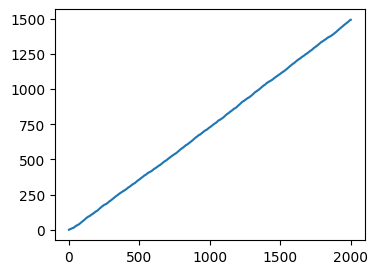

In [8]:
plt.figure(figsize=(4, 3))
plt.plot(np.cumsum(rewards))

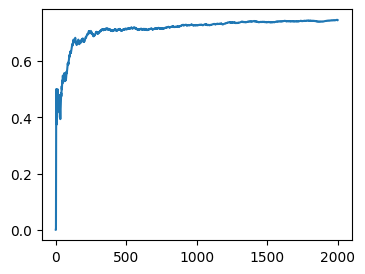

In [9]:
plt.figure(figsize=(4, 3))
plt.plot(rates)

In [10]:
rates_list = []
for i in range(10):
    arms = 10
    bandit = Bandit(arms)
    agent = Agent(arms)
    steps = 500
    
    rewards = []
    total_reward = 0
    rates = []
    
    for step in range(steps):
        arm = agent.get_action()
        reward = bandit.play(arm)
        agent.update(arm, reward)
        total_reward += reward
        rates.append(total_reward / (step+1))
    rates_list.append(rates)

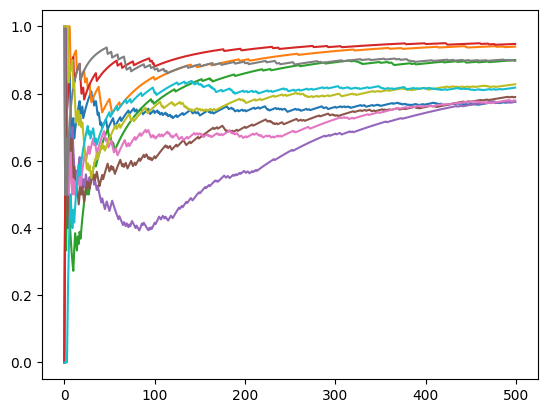

In [11]:
for rates in rates_list:
    plt.plot(rates)

### 非稳态 bandit

In [14]:
class Bandit:
    def __init__(self, arms=10):
        # 一旦设置，就不再改变
        self.rates = np.random.rand(arms)

In [15]:
class NonStatBandit:
    def __init__(self, arms=10):
        self.rates = np.random.rand(arms)
    def play(self, arm):
        rate = self.rates[arm]
        self.rates += 0.1 * np.random.randn(self.arms)
        print(self.rates)
        if rate > np.random.rand():
            return 1
        return 0

- reward 的样本均值
    - $Q_n=\frac{R_1+R_2+\cdots+R_n}{n}=\frac1nR_1+\frac1nR_2+\cdots+\frac1nR_n$
    - 所有时刻获得奖励都被平等对待
- 样本均值的高效更新方法
    - $Q_n=Q_{n-1}+\frac1n(R_n-Q_{n-1})$
- 二者完全等价（在稳态情况下）
    - $Q_n=\frac{n-1}{n}Q_{n-1}+\frac1nR_n$
    - 如果 $Q_n=\frac1n\sum R_i$，则有 $Q_{n-1}=\frac{1}{n-1}\sum_{i=1}^{n-1} R_i$
    - 则有 $Q_n=\frac1n\sum_{i=1}^{n-1}\sum R_i+\frac1nR_n=\frac1n\sum_{i=1}^nR_n$
- 对于非稳态问题
    - 环境随时间而变化，过去获得的奖励的重要性应该随着时间的推移而下降，反过来要给新获得的奖励以更大的权重